## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Import Data

In [2]:
mta_df = pd.read_csv("./Turnstile_Usage_Data__2017.csv")

## Convert to Datetime Object

In [3]:
mta_df['datetime'] = pd.to_datetime(mta_df['Date'] + mta_df['Time'], 
                                  format='%m/%d/%Y%H:%M:%S')

## Select timeframe (if applicable)

In [4]:
start_date = '20170101'
end_date = '20170331'
mta_df = mta_df[(mta_df['datetime'] > start_date) & (mta_df['datetime'] < end_date) ]

## Add a column of day_of_week and a column of holiday

In [6]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

mta_df['day'] = mta_df['datetime'].dt.dayofweek

cal = calendar()
holidays = cal.holidays(start=mta_df.Date.min(), end=mta_df.Date.max())

mta_df['Holiday'] = mta_df['Date'].isin(holidays)

## Calculate Entries in Each Time Interval

In [7]:
# sort records by C/A, Unit, SCP, and Station for calculation
mta_df = mta_df.sort_values(['C/A', 'Unit', 'SCP', 'Station'])

# create columns of C/A, Unit, SCP, and Station with one row shift down
mta_df['Entries_shifted'] = mta_df['Entries'].shift(1)
mta_df['C/A_shifted'] = mta_df['C/A'].shift(1)
mta_df['Unit_shifted'] = mta_df['Unit'].shift(1)
mta_df['SCP_shifted'] = mta_df['SCP'].shift(1)
mta_df['Station_shifted'] = mta_df['Station'].shift(1)

# only calcuate the entries difference if C/A, Unit, SCP, and Station are same
cond = (mta_df['C/A_shifted'] == mta_df['C/A'])\
        &(mta_df['Unit_shifted'] == mta_df['Unit'])\
        &(mta_df['SCP_shifted'] == mta_df['SCP'])\
        &(mta_df['Station_shifted'] == mta_df['Station'])

mta_df['Entries_4_hours'] = mta_df['Entries'] - mta_df['Entries_shifted'] 
mta_df['Entries_4_hours_cleaned'] = np.where(cond, mta_df['Entries_4_hours'], 0)

In [8]:
# drop shifted columns

mta_df = mta_df.drop(['C/A_shifted', 'Unit_shifted', 'SCP_shifted', 'Station_shifted', 'Entries_shifted'], axis=1)

### There are still rows with negative entries number, need to decide what to do with them

In [9]:
# drop record with negative entries every 4 hours
mta_df = mta_df[mta_df['Entries_4_hours_cleaned'] > 0]

## Total number of turnstile

In [18]:
mta_df.groupby(['C/A','Unit', 'SCP', 'Station'])['Entries_4_hours_cleaned'].sum().count()

4461

## total number of station

In [19]:
mta_df.groupby(['Station'])['Entries_4_hours_cleaned'].sum().count()

376

## Statistic Summary of Cleaned Entries Every 4 Hours

In [10]:
# explore entries distribution
mta_df['Entries_4_hours_cleaned'].describe()

count    1.762237e+06
mean     5.839255e+03
std      2.405970e+06
min      1.000000e+00
25%      3.000000e+01
50%      1.090000e+02
75%      2.820000e+02
max      2.122193e+09
Name: Entries_4_hours_cleaned, dtype: float64

## distribution of entries in every 4 hours at a turnstile

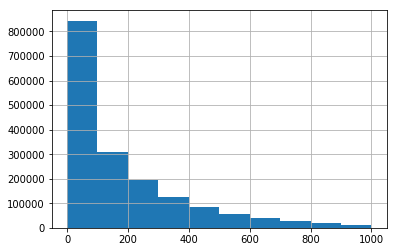

In [11]:
mta_df['Entries_4_hours_cleaned'].hist(range=[0, 1e3])

## distribution of daily entries at a turnstile

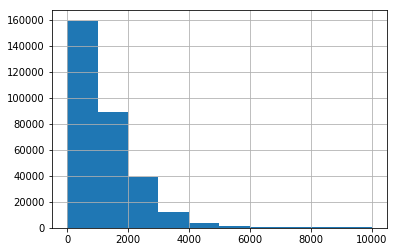

In [12]:
#mta_df.groupby(['C/A','Unit', 'SCP', 'Station', 'Date'])['Entries_4_hours_cleaned'].sum()
mta_df.groupby(['C/A','Unit', 'SCP', 'Station','Date'])['Entries_4_hours_cleaned'].sum().hist(range=[0, 1e4])

## distribution of daily entries at a station

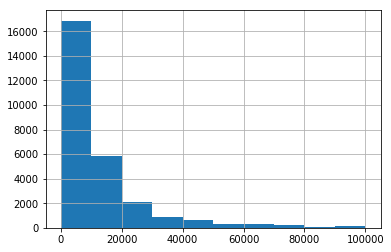

In [13]:
mta_df.groupby(['Station','Date'])['Entries_4_hours_cleaned'].sum().hist(range=[0, 1e5])

## distribution of sum of entries on a day of the week at a station

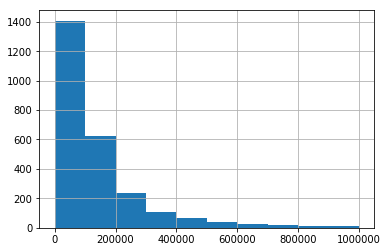

In [15]:
#mta_df.groupby(['Station', 'day'], as_index=False)['Entries_4_hours_cleaned'].sum()
mta_df.groupby(['Station', 'day'])['Entries_4_hours_cleaned'].sum().hist(range=[0,1e6])